In [3]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/26326
# 标题：【复现】C-VIX 中国版 VIX 编制手册

import pickle
import json

import talib
import numpy as np
import pandas as pd
import tushare as ts

from tqdm import *
from jqdata import *
from datetime import timedelta
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.gridspec as mg # 不规则子图

%matplotlib inline
# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']
#mpl.rcParams['font.family'] = 'serif'
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

# 请根据自己的情况填写ts的token
setting = json.load(open('../config.json'))
pro = ts.pro_api(setting['token'])

# VIX计算方法

白皮书具体步骤:

[CBOE Volatility Index](http://www.cboe.com/micro/vix/vixwhite.pdf)

[CBOE Skew Index](http://www.cboe.com/micro/skew/documents/skewwhitepaperjan2011.pdf)

$$\sigma^2=\frac{2}{T}\sum^{n}_{i=1}\frac{\Delta K_i}{K^{2}_{i}}e^{rT}Q(K_i)-\frac{1}{T}(\frac{F}{K_0}-1)^2$$



CBOE白皮书对无风险收益率的描述是:
>The risk-free interest rates, $R_1$ and $R_2$, are yields based on U.S. Treasury yield curve rates (commonly referred to as“Constant Maturity Treasury” rates or CMTs), to which a cubic spline is applied to derive yields on the expiration dates ofrelevant SPX options. 

所有在这里我用的SHIBOR利率,具体处理见**GetShiBor**函数

In [4]:
class CH_VIX(object):
    
    def __init__(self,symbol,start_date,end_date,read=False):
        
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        
        self.read = read
        self.OptData = pd.DataFrame()
        
        
    def GetCBOE_VIX(self) -> pd.Series:
        
        if self.read:
            
            self.OptData = pd.read_csv('../Data/OptData.csv',index_col=0,parse_dates=['date'])
        
        else:
            
            self.PrepareData()
        
        
        start_dt = min(self.OptData['date'])
        end_dt = max(self.OptData['date'])
        
        df_rate = self.GetShiBor(start_dt, end_dt)

        date_index = [] # 储存index
        vix_value = []  # 储存vix
        skew_value = [] # 储存skew

        for trade_date, slice_df in tqdm(self.OptData.groupby('date'), desc='计算中..',leave=True):

            maturity, df_jy, df_cjy = self.filter_contract(slice_df)
            
            # 获取无风险收益             
            rf_rate_jy = df_rate.loc[trade_date, int(maturity['jy'] * 365)]             
            rf_rate_cjy = df_rate.loc[trade_date, int(maturity['cjy'] * 365)]

            # 计算远期价格
            fp_jy = self.cal_forward_price(maturity['jy'], rf_rate=rf_rate_jy, df=df_jy)
            fp_cjy = self.cal_forward_price(maturity['cjy'], rf_rate=rf_rate_cjy, df=df_cjy)

            # 计算中间价格
            df_mp_jy = self.cal_mid_price(maturity['jy'], df_jy, fp_jy)
            df_mp_cjy = self.cal_mid_price(maturity['cjy'], df_cjy, fp_cjy)

            # 计算行权价差
            df_diff_k_jy = self.cal_k_diff(df_jy)
            df_diff_k_cjy = self.cal_k_diff(df_cjy)

            # 计算VIX
            df_tovix_jy = pd.concat([df_mp_jy, df_diff_k_jy], axis=1).reset_index()
            df_tovix_cjy = pd.concat([df_mp_cjy, df_diff_k_cjy],
                                     axis=1).reset_index()

            nearest_k_jy = self._nearest_k(df_jy, fp_jy)
            nearest_k_cjy = self._nearest_k(df_cjy, fp_cjy)


            vix = self.cal_vix(df_tovix_jy, fp_jy, rf_rate_jy, maturity['jy'],
                          nearest_k_jy, df_tovix_cjy, fp_cjy, rf_rate_cjy,
                          maturity['cjy'], nearest_k_cjy)

            skew = self.cal_skew(df_tovix_jy, fp_jy, rf_rate_jy, maturity['jy'],
                            nearest_k_jy, df_tovix_cjy, fp_cjy, rf_rate_cjy,
                            maturity['cjy'], nearest_k_cjy)

            date_index.append(trade_date)
            vix_value.append(vix)
            skew_value.append(skew)

        data = pd.DataFrame({
            "CH_VIX": vix_value,
            "CH_SKEW": skew_value
        },
                            index=date_index)
        
        data.fillna(method='pad', inplace=True)
        
        data.index = pd.DatetimeIndex(data.index)
        

        return data

    # 获取期权信息
    def GetOptContractBasicInfo(self) -> pd.DataFrame:

        # CO-认购期权，PO-认沽期权
        OptionContractBasicInfo = opt.run_query(
            query(opt.OPT_CONTRACT_INFO.list_date,
                  opt.OPT_CONTRACT_INFO.exercise_date,
                  opt.OPT_CONTRACT_INFO.exercise_price,
                  opt.OPT_CONTRACT_INFO.contract_type,
                  opt.OPT_CONTRACT_INFO.code).filter(
                      opt.OPT_CONTRACT_INFO.underlying_symbol == self.symbol,
                opt.OPT_CONTRACT_INFO.last_trade_date >= self.start_date,
            opt.OPT_CONTRACT_INFO.list_date <= self.end_date))

        return OptionContractBasicInfo


    # 获取期权日线行情
    @staticmethod
    def GetOptDailyPrice(code_list:list) -> pd.DataFrame:
        
        price_temp = []  # 储存数据

        # 获取某合约代码日数据
        for CODE in tqdm(code_list, desc='DownLoad Daily Price',leave=True):

            q = query(
                opt.OPT_DAILY_PRICE.date, opt.OPT_DAILY_PRICE.close,
                opt.OPT_DAILY_PRICE.code).filter(opt.OPT_DAILY_PRICE.code == CODE)

            price_temp.append(opt.run_query(q))
        
        return pd.concat(price_temp)


    # 数据准备
    def PrepareData(self):
        
        start = self.start_date
        end = self.end_date
        
        # 获取期权基本信息
        OptContractBasicInfo = self.GetOptContractBasicInfo()
        # 获取期权合约代码
        code_list = OptContractBasicInfo['code'].unique().tolist()
        # 获取日线行情
        OptDailyPrice = self.GetOptDailyPrice(code_list)
        
        # 查询计算期里的日线
        date_ = pd.to_datetime(OptDailyPrice['date'])
        OptDailyPrice = OptDailyPrice[(date_>=start)&(date_<=end)]
        
        OptData = pd.merge(OptDailyPrice, OptContractBasicInfo, on='code')

        # 计算到行权日距离
        ## T的计算
        OptData['maturity'] = (pd.to_datetime(OptData['exercise_date']) -
                               pd.to_datetime(OptData['date'])) / timedelta(365)

        use_col = 'date,close,contract_type,exercise_price,maturity'.split(',')

        df_use = OptData[use_col].copy()

        df_use['contract_type'] = df_use['contract_type'].map({
            "CO": "call",
            "PO": "put"
        })
        df_use = df_use.sort_values('date')

        print('数据已储存../Data/OptData.csv')
        df_use.to_csv('../Data/OptData.csv')
        
        self.OptData = df_use

    # 通过ts获取SHIBOR数据
    @staticmethod
    def GetShiBor(startDate: str, endDate: str) -> pd.DataFrame:
        '''
        startDate,endDate 格式需要为yyyy-mm-dd
        '''
       
        # 单次最大2000行

        limit = 2000
        dates = [x.strftime('%Y%m%d') for x in get_trade_days(startDate, endDate)]
        n_days = len(dates)

        if n_days > limit:

            n = n_days // limit
            df_list = []
            i = 0
            pos1, pos2 = n * i, n * (i + 1) - 1

            while pos2 < n_days:
                # 根据@艾布拉姆斯的提示 修复此部分
                df = pro.shibor(
                    start_date=dates[pos1], end_date=dates[pos2]).set_index('date')

                df_list.append(shibor_df)
                i += 1
                pos1, pos2 = n * i, n * (i + 1) - 1

            if pos1 < n_days:

                df = pro.shibor(
                    start_date=dates[pos1], end_date=dates[-1]).set_index('date')

                df_list.append(df)

            shibor_df = pd.concat(df_list, axis=0)

        else:

            shibor_df = pro.shibor(
                start_date=startDate.strftime('%Y%m%d'),
                end_date=endDate.strftime('%Y%m%d')).set_index('date')

        shibor_df.index = pd.DatetimeIndex(shibor_df.index)
        shibor_df.sort_index(inplace=True)
        
        # 差值
        def _interpld_fun(r):

            y_vals = r.values / 100

            daily_range = np.arange(1, 361)
            periods = [1, 7, 14, 30, 90, 180, 270, 360]

            # 插值
            f = interp1d(periods, y_vals, kind='cubic')
            t_ser = pd.Series(data=f(daily_range), index=daily_range)

            return t_ser

        shibor_df = shibor_df.apply(lambda x: _interpld_fun(x), axis=1)

        shibor_df.index = pd.DatetimeIndex(shibor_df.index)

        return shibor_df


    # 选出当日的近远月合约(且到期日大于1周)
    def filter_contract(self,cur_df: pd.DataFrame):

        # 今天在交易的合约的到期日
        ex_t = cur_df['maturity'].unique()
        # 选择到期日大于等于5天的数据
        ex_t = ex_t[ex_t >= 5. / 365]
        
        # 到期日排序，最小两个为近月、次近月
        try:
            jy_dt, cjy_dt = np.sort(ex_t)[:2]
        
        except ValueError:
            
            print(ex_t,np.sort(ex_t)[:2])
        
        maturity_dict = dict(zip(['jy', 'cjy'], [jy_dt, cjy_dt]))

        # 选取近月及次近月合约
        cur_df = cur_df[cur_df['maturity'].isin([jy_dt, cjy_dt])]

        keep_cols = ['close', 'contract_type', 'exercise_price']

        cur_df_jy = cur_df.query('maturity==@jy_dt')[keep_cols]
        cur_df_cjy = cur_df.query('maturity==@cjy_dt')[keep_cols]

        cur_df_jy = cur_df_jy.pivot_table(
            index='exercise_price', columns='contract_type', values='close')

        cur_df_cjy = cur_df_cjy.pivot_table(
            index='exercise_price', columns='contract_type', values='close')

        # TODO:df 中可能存在缺少call,put的情况需要加过滤check一下

        # 检查字段
        cur_df_jy = self._check_fields(cur_df_jy)
        cur_df_cjy = self._check_fields(cur_df_cjy)
        
        # 绝对值差异
        cur_df_jy['diff'] = np.abs(cur_df_jy['call'] - cur_df_jy['put'])
        cur_df_cjy['diff'] = np.abs(cur_df_cjy['call'] - cur_df_cjy['put'])

        return maturity_dict, cur_df_jy, cur_df_cjy


    # 字段检查
    @staticmethod
    def _check_fields(x_df: pd.DataFrame) -> pd.DataFrame:

        # 目标字段
        target_fields = ['call', 'put']

        for col in target_fields:

            if col not in x_df.columns:
                print("%s字段为空" % col)
                df[col] = 0

        return x_df


    # 计算远期价格
    @staticmethod
    def cal_forward_price(maturity: dict, rf_rate: float,
                          df: pd.DataFrame) -> float:

        # 获取认购与认沽的绝对值差异最小值的信息
        min_con = df.sort_values('diff').iloc[0]

        # 获取的最小exercise_price
        k_min = min_con.name

        # F = Strike Price + e^RT x (Call Price - Put Price)
        f_price = k_min + np.exp(maturity * rf_rate) * (
            min_con['call'] - min_con['put'])

        return f_price


    # 计算中间价格
    def cal_mid_price(self,maturity: dict, df: pd.DataFrame,
                      forward_price: float) -> pd.DataFrame:

        def _cal_mid_fun(x, val: float):
            res = None
            if x['exercise_price'] < val:
                res = x['put']
            elif x['exercise_price'] > val:
                res = x['call']
            else:
                res = (x['put'] + x['call']) / 2
            return res

        # 小于远期价格且最靠近的合约的行权价
        m_k = self._nearest_k(df, forward_price)

        ret = pd.DataFrame(index=df.index)

        # 计算中间件
        m_p_lst = df.reset_index().apply(lambda x: _cal_mid_fun(x, val=m_k), axis=1)

        ret['mid_p'] = m_p_lst.values

        return ret


    # 寻找最近合约
    @staticmethod
    def _nearest_k(df: pd.DataFrame, forward_price: float) -> float:

        # 行权价等于或小于远期价格的合约
        temp_df = df[df.index <= forward_price]
        if temp_df.empty:

            temp_df = df

        m_k = temp_df.sort_values('diff').index[0]

        return m_k


    # 计算行权价间隔
    @staticmethod
    def cal_k_diff(df: pd.DataFrame) -> pd.DataFrame:

        arr_k = df.index.values
        ret = pd.DataFrame(index=df.index)

        res = []
        res.append(arr_k[1] - arr_k[0])
        res.extend(0.5 * (arr_k[2:] - arr_k[0:-2]))
        res.append(arr_k[-1] - arr_k[-2])
        ret['diff_k'] = res
        return ret


    # 计算VIX
    @staticmethod
    def cal_vix_sub(df: pd.DataFrame, forward_price: float, rf_rate: float,
                    maturity: float, nearest_k: float):

        def _vix_sub_fun(x):
            ret = x['diff_k'] * np.exp(rf_rate * maturity) * x['mid_p'] / np.square(
                x['exercise_price'])
            return ret

        temp_var = df.apply(lambda x: _vix_sub_fun(x), axis=1)

        sigma = 2 * temp_var.sum() / maturity - np.square(forward_price /
                                                          nearest_k - 1) / maturity

        return sigma


    # 计算近、次近月VIX
    def cal_vix(self,df_jy: pd.DataFrame, forward_price_jy: float, rf_rate_jy: float,
                maturity_jy: float, nearest_k_jy: float, df_cjy: pd.DataFrame,
                forward_price_cjy: float, rf_rate_cjy: float, maturity_cjy: float,
                nearest_k_cjy: float):

        sigma_jy = self.cal_vix_sub(df_jy, forward_price_jy, rf_rate_jy, maturity_jy,
                               nearest_k_jy)

        sigma_cjy = self.cal_vix_sub(df_cjy, forward_price_cjy, rf_rate_cjy,
                                maturity_cjy, nearest_k_cjy)

        w = (maturity_cjy - 30.0 / 365) / (maturity_cjy - maturity_jy)

        to_sqrt = maturity_jy * sigma_jy * w + maturity_cjy * sigma_cjy * (1 - w)

        if to_sqrt >= 0:

            vix = 100 * np.sqrt(to_sqrt * 365.0 / 30)

        else:

            vix = np.nan

        return vix


    # 计算SKEW
    def cal_skew(self,df_jy:pd.DataFrame, forward_price_jy:float, rf_rate_jy:float, maturity_jy:float, nearest_k_jy:float,
                 df_cjy:pd.DataFrame, forward_price_cjy:float, rf_rate_cjy:float, maturity_cjy:float,
                 nearest_k_cjy:float)->float:

        s_jy = self.cal_moments_sub(df_jy, maturity_jy, rf_rate_jy, forward_price_jy,
                               nearest_k_jy)

        s_cjy = self.cal_moments_sub(df_cjy, maturity_cjy, rf_rate_cjy,
                                forward_price_cjy, nearest_k_cjy)

        w = (maturity_cjy - 30.0 / 365) / (maturity_cjy - maturity_jy)

        skew = 100 - 10 * (w * s_jy + (1 - w) * s_cjy)

        return skew

    @staticmethod
    def cal_epsilon(forward_price:float, nearest_k:float)->tuple:

        e1 = -(1 + np.log(forward_price / nearest_k) - forward_price / nearest_k)

        e2 = 2 * np.log(nearest_k / forward_price) * (
            nearest_k / forward_price - 1) + np.square(
                np.log(nearest_k / forward_price)) * 0.5

        e3 = 3 * np.square(np.log(nearest_k / forward_price)) * (
            np.log(nearest_k / forward_price) / 3 - 1 + forward_price / nearest_k)

        return e1, e2, e3


    def cal_moments_sub(self,df:pd.DataFrame, maturity:float, rf_rate:float, forward_price:float, nearest_k:float)->float:

        e1, e2, e3 = self.cal_epsilon(forward_price, nearest_k)

        temp_p1 = -np.sum(
            df['mid_p'] * df['diff_k'] / np.square(df['exercise_price']))

        p1 = np.exp(maturity * rf_rate) * (temp_p1) + e1

        temp_p2 = np.sum(df['mid_p'] * df['diff_k'] * 2 *
                         (1 - np.log(df['exercise_price'] / forward_price)) /
                         np.square(df['exercise_price']))
        p2 = np.exp(maturity * rf_rate) * (temp_p2) + e2

        temp_p3 = temp_p3 = np.sum(
            df['mid_p'] * df['diff_k'] * 3 *
            (2 * np.log(df['exercise_price'] / forward_price) -
             np.square(np.log(df['exercise_price'] / forward_price))) /
            np.square(df['exercise_price']))

        p3 = np.exp(maturity * rf_rate) * (temp_p3) + e3

        s = (p3 - 3 * p1 * p2 + 2 * p1**3) / (p2 - p1**2)**(3 / 2)

        return s

In [5]:
# 获取CBOE的VIX SKEW
VIX = CH_VIX('510050.XSHG','2015-01-01','2020-04-10',True)
VIX_ser = VIX.GetCBOE_VIX()

计算中..: 100%|██████████| 1259/1259 [01:10<00:00, 17.98it/s]


array([AxesSubplot(0.125,0.570909;0.775x0.309091),
       AxesSubplot(0.125,0.2;0.775x0.309091)], dtype=object)

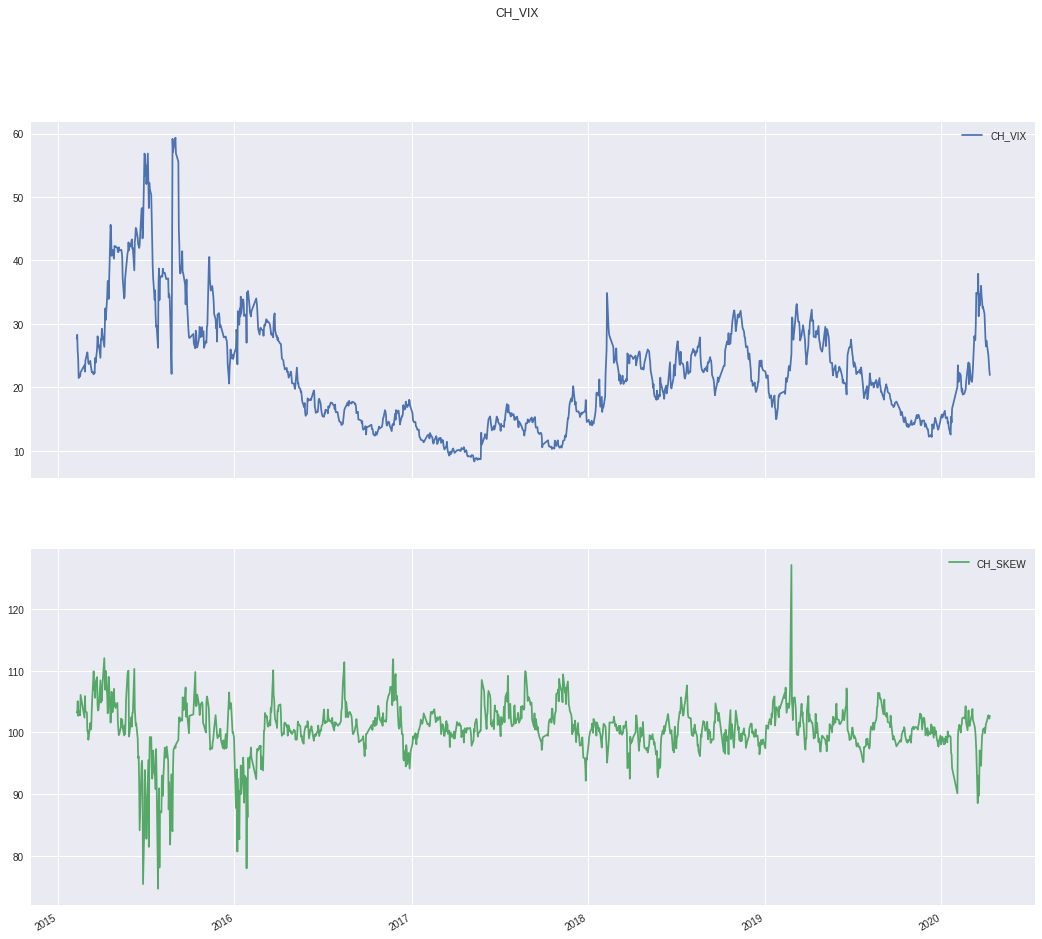

In [6]:
VIX_ser.plot(figsize=(18, 16), title='CH_VIX', subplots=True) 

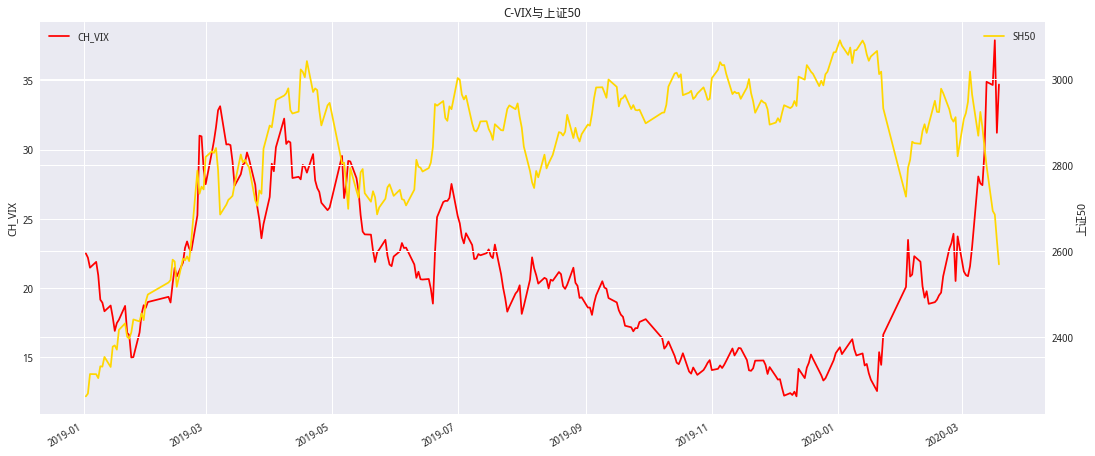

In [5]:
SH50 = get_price('000016.XSHG','2019-01-01','2020-03-19',fields='close')

mpl.rcParams['font.family'] = 'serif'
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(111)
ax1.set_title('C-VIX与上证50')
VIX_ser['CH_VIX'].reindex(SH50.index).plot(ax=ax1,color='r')
ax1.set_ylabel('CH_VIX')
plt.legend(loc=2)

ax2 = ax1.twinx()
SH50['close'].plot(ax=ax2,color='#FFD700',label='SH50')
ax2.set_ylabel('上证50')
plt.legend()
plt.show()

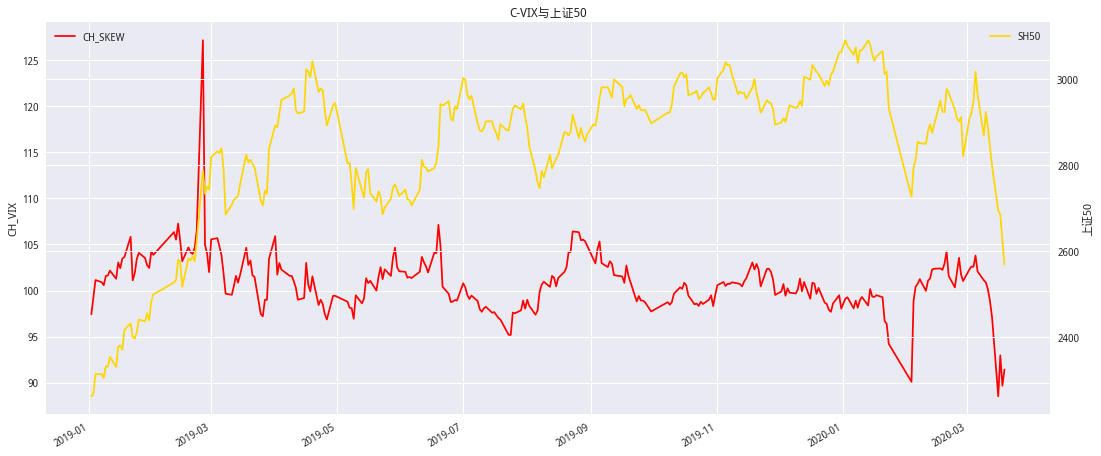

In [6]:
mpl.rcParams['font.family'] = 'serif'
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(111)
ax1.set_title('C-VIX与上证50')
VIX_ser['CH_SKEW'].reindex(SH50.index).plot(ax=ax1,color='r')
ax1.set_ylabel('CH_VIX')
plt.legend(loc=2)

ax2 = ax1.twinx()
SH50['close'].plot(ax=ax2,color='#FFD700',label='SH50')
ax2.set_ylabel('上证50')
plt.legend()
plt.show()

# VIX择时

>波动率VIX指数是跟踪市场波动性的指数，一般通过标的期权的隐含波动率计算得来，以芝加哥期权交易所的VIX指数为例，如标的期权的隐含波动率越高，则VIX指数相应越高，一般而言，该指数反映出投资者愿意付出多少成本去对冲投资风险。业内认为，当VIX越高时，表示市场参与者预期后市波动程度会更加激烈，同时也反映其不安的心理状态；相反，VIX越低时，则反映市场参与者预期后市波动程度会趋于缓和的心态。因此，VIX又被称为投资人恐慌指标（The Investor Fear Gauge）。

**策略思路**


- 当VIX指数快速上升时，表示市场恐慌情绪蔓延，产生卖出信号
- 当VIX指数快速下降时，恐慌情绪有所舒缓，产生买入信号

实际回测时:卖出买入信号均用来买卖华夏上证50ETF基金

具体信号构造：
1. 计算VIX的快慢均线 
2. 死叉买入 金叉卖出

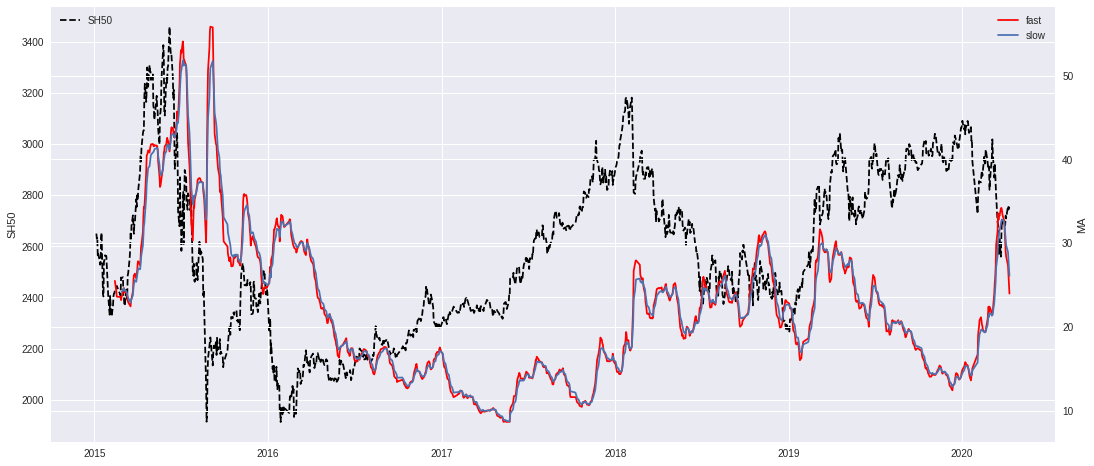

In [7]:
SH50 = get_price('000016.XSHG','2015-01-01','2020-04-10',fields='close')

fast_ma = talib.EMA(VIX_ser['CH_VIX'],5)
slow_ma = talib.EMA(VIX_ser['CH_VIX'],10)

plt.figure(figsize=(18,8))
plt.plot(SH50['close'],label='SH50',color='black',ls='--')
plt.ylabel('SH50')
plt.legend(loc=2)

plt.twinx()

plt.plot(fast_ma,label='fast',color='r')
plt.plot(slow_ma,label='slow')
plt.ylabel('MA')
plt.legend()
plt.show()

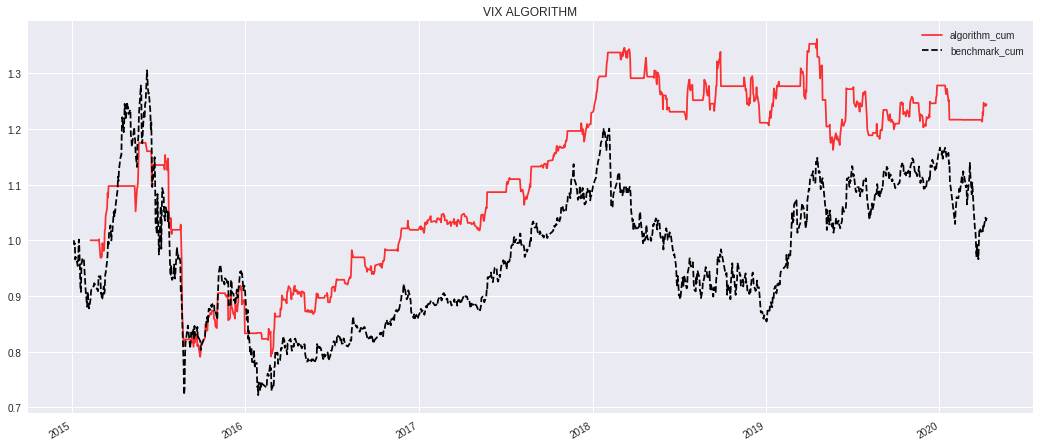

In [8]:
# 
flag = np.where(slow_ma >= fast_ma,1,0)
next_ret = SH50['close'].pct_change().shift(-1)

# 
plt.figure(figsize=(18,8))
plt.title('VIX ALGORITHM')

(1+flag*next_ret.reindex(fast_ma.index)).cumprod().plot(color='r',alpha=0.8)
(SH50['close'] / SH50['close'][0]).plot(color='black',ls='--')

plt.legend(['algorithm_cum','benchmark_cum'])

## VIX对应的下期收益

In [10]:
# 显示数据分布
def ShowDistribution(singal_ser: pd.DataFrame, close_ser: pd.DataFrame):

    test = pd.concat([singal_ser, close_ser.pct_change().shift(-1)], axis=1)
    test = test.dropna()
    test.columns = ['singal', 'next_ret']

    v = pd.cut(test['singal'], bins=50)
    test['group'] = v

    mean_ret = test.groupby('group')['next_ret'].mean()

    plt.rcParams['font.family'] = 'serif'
    plt.figure(figsize=(18, 6))
    
    # 用于设置不规则子图
    gs = mg.GridSpec(1, 3)

    # 子图-信号分布
    plt.subplot(gs[0, 0])
    plt.title('信号分布')
    sns.distplot(singal_ser.dropna())

    plt.axvline(singal_ser.mean(), ls='--', color='r', alpha=0.5, label='mean')

    plt.axvline(
        singal_ser.mean() + 2 * singal_ser.std(),
        ls='--',
        color='black',
        alpha=0.5,
        label='2std')

    plt.axvline(
        singal_ser.mean() - 2 * singal_ser.std(),
        ls='--',
        color='black',
        alpha=0.5,
        label='-2std')

    plt.legend()

    # 子图-信号与下期平均收益
    plt.subplot(gs[0, 1:3])
    plt.title('信号与下期平均收益')

    # 设置标签
    labels = mean_ret.index
    # 大于0
    a = np.where(mean_ret >= 0, mean_ret, 0)
    # 小于0
    b = np.where(mean_ret < 0, mean_ret, 0)
    plt.bar(range(len(a)), a, tick_label=labels, color='r')
    plt.bar(range(len(b)), b, tick_label=labels, color='green')
    # 标签旋转
    plt.xticks(rotation=90)
    plt.show()

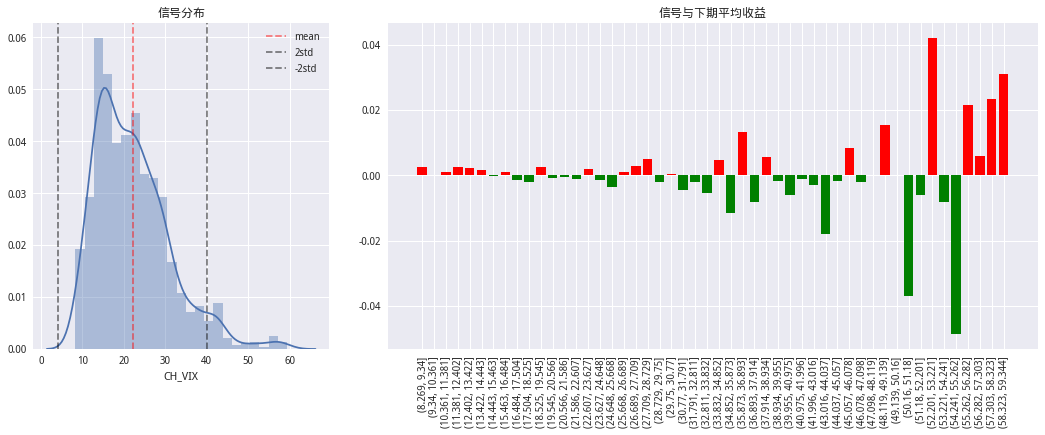

In [11]:
ShowDistribution(VIX_ser['CH_VIX'],SH50['close'])

构造单向波动率信号

In [12]:
PCT_CHG = SH50['close'].pct_change()
PCT_CHG = PCT_CHG.reindex(VIX_ser.index)

up = np.where(PCT_CHG > 0,VIX_ser['CH_VIX'],0)
down = np.where(PCT_CHG < 0,VIX_ser['CH_VIX'],0)

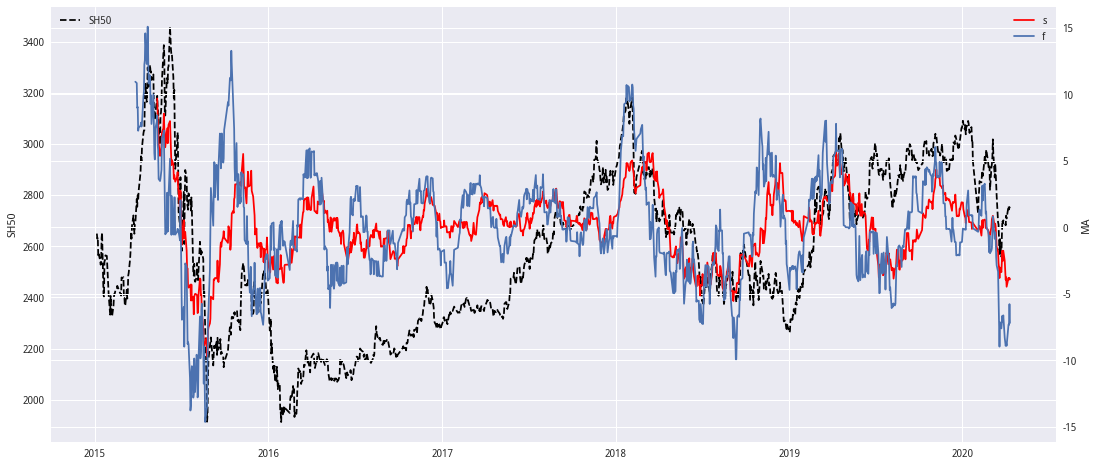

In [38]:
singal = pd.Series(up - down,index = PCT_CHG.index)
fast_ma = talib.SMA(singal,30)
slow_ma = talib.SMA(singal,60)

plt.figure(figsize=(18,8))
plt.plot(SH50['close'],label='SH50',color='black',ls='--')
plt.ylabel('SH50')
plt.legend(loc=2)

plt.twinx()

plt.plot(slow_ma,label='s',color='r')
plt.plot(fast_ma,label='f')
plt.ylabel('MA')
plt.legend()
plt.show()

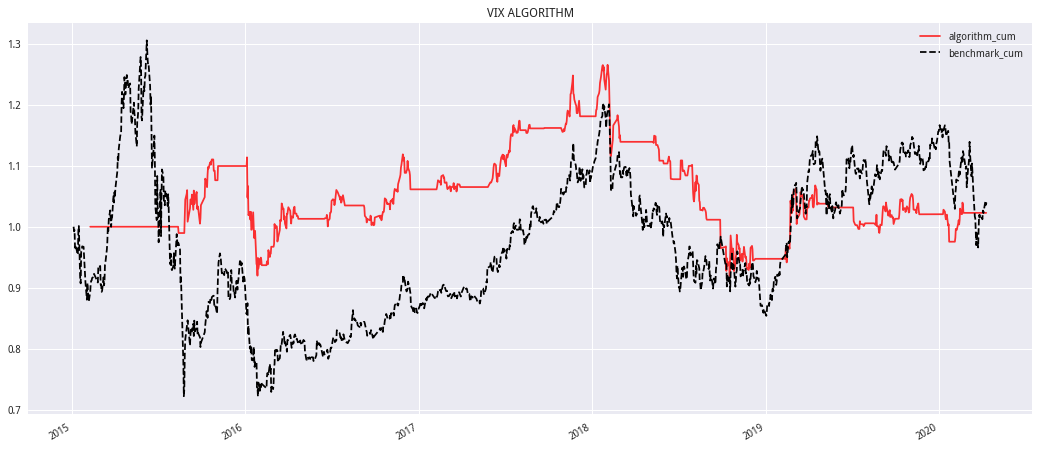

In [39]:
# 
flag = np.where(slow_ma < fast_ma,1,0)
next_ret = SH50['close'].pct_change().shift(-1)

# 
plt.figure(figsize=(18,8))
plt.title('VIX ALGORITHM')

(1+flag*next_ret.reindex(fast_ma.index)).cumprod().plot(color='r',alpha=0.8)
(SH50['close'] / SH50['close'][0]).plot(color='black',ls='--')

plt.legend(['algorithm_cum','benchmark_cum'])